<a href="https://colab.research.google.com/github/ankit-kothari/Topic-Modeling/blob/master/TOPIC_MODELING_USING_LDA_AND_NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyspark

In [ ]:
##GENERAL
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import csv
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

##SPACY
import spacy
nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('en_core_web_md')
#nlp = spacy.load('en_core_web_lg')
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from spacy.pipeline import SentenceSegmenter
from spacy import displacy

##NLTK
import nltk
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer

##SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

#spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, array
from pyspark.sql.types import StringType

##DATA CLEANING

In [ ]:
contraction_mapping = {"ain't": "is not","don't": "do not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "w/":"with", "cnt":"cannot", "w/o":"without","u":"you"}


def spacy_preprocessing(text):
    #print(text)
    text = re.sub(r"\S*\w*.(com)\S*", "",text) #replaces any email or websitw with space
    text = re.sub(r"\b([a-zA-Z]{1})\b", " ", text) #replaces single random characters in the text with space
    text = re.sub(r"[^a-zA-Z]"," ",text) #replaces special characters with spaces
    text = re.sub(r"(.)\1{3,}", r"\1", text) #replaces multiple character with a word with one like pooooost will be post
    text = re.sub(r"\s{2,}", r" ", text) #replaces multiple space in the line with single space
    
    
    tokens = text.split(" ")
    #print(tokens)
    clean_tokens = [contraction_mapping[i] if i in contraction_mapping else i for i in tokens]
    text = " ".join(clean_tokens)
    #except:
    #text=text
    clean_text=[]
    for token in nlp(text):
       if (token.lemma_ != "-PRON-") & (token.text not in nlp.Defaults.stop_words):
           clean_text.append(token.text.lower())
       elif (token.lemma_ == "-PRON-")  & (token.text not in nlp.Defaults.stop_words):
           clean_text.append(token.text.lower())
       else:
           continue
    clean_string = " ".join(clean_text).lstrip()
    #print(type(clean_string))
    return clean_string

##PYSPARK DATA TRANSFORMATION

1. Load in the data as pyspark dataframe

In [ ]:
s2p_start= time.time()
spark = SparkSession.builder.appName('TopicModeling').getOrCreate()
df = spark.read.csv('/content/drive/My Drive/data/Womens Clothing E-Commerce Reviews 2.csv',inferSchema=True, header=True)

In [ ]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Clothing ID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Recommended IND: string (nullable = true)
 |-- Positive Feedback Count: string (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)



2. Creating a custom transformation function to clean the text in **Reviews** Column

In [ ]:
determine_winner_udf = udf(spacy_preprocessing, StringType())
# DROPPING ANY NULL VALUES
df_review = df.select('Review Text')
df_review_drop = df_review.dropna()

3. Adding a new column **cleanReview** to store the clean Reviews after data cleaning

In [ ]:
df_reviews = df_review_drop.withColumn('cleanReview', determine_winner_udf(df_review_drop['Review Text']))
df_reviews.show(5)

+--------------------+--------------------+
|         Review Text|         cleanReview|
+--------------------+--------------------+
|Absolutely wonder...|absolutely wonder...|
|"Love this dress!...|love dress sooo p...|
|I had such high h...|high hopes dress ...|
|I love, love, lov...|love love love ju...|
|This shirt is ver...|this shirt flatte...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df_reviews.printSchema()

root
 |-- Review Text: string (nullable = true)
 |-- cleanReview: string (nullable = true)



In [ ]:
data_spark = df_reviews.toPandas()
s2p_end = time.time()-s2p_start
print(f'Time Taken for Spark Transformation {s2p_end:.0f} seconds')

Time Taken for Spark Transformation 332 seconds


In [ ]:
pd.set_option('display.max_colwidth', -1)
data_spark

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Review Text,cleanReview
0,Absolutely wonderful - silky and sexy and comfortable,absolutely wonderful silky sexy
1,"""Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"""". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.""",love dress sooo pretty happened find store glad bc ordered online bc petite bought petite love length hits little knee definitely true midi truly petite
2,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",high hopes dress wanted work initially ordered petite small usual size found outrageously small small fact zip reordered petite medium ok overall half fit nicely half tight layer somewhat cheap net layers imo major design flaw net layer sewn directly zipper
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",love love love jumpsuit fun flirty fabulous time wear
4,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,this shirt flattering adjustable tie perfect length wear leggings sleeveless pairs cardigan love shirt
...,...,...
24709,"It reminds me of maternity clothes. soft, stretchy, shiny material. cut is flattering and drapes nicely. i only found one button to close front... looked awkward. nice long sleeves.",it reminds maternity clothes soft stretchy shiny material cut flattering drapes nicely found button close looked awkward nice long sleeves
24710,General Petite,general petite
24711,"This fit well, but the top was very see through. this never would have worked for me. i'm glad i was able to try it on in the store and didn't order it online. with different fabric, it would have been great.",this fit worked glad able try store didn order online different fabric great
24712,"I bought this dress for a wedding i have this summer, and it's so cute. unfortunately the fit isn't perfect. the medium fits my waist perfectly, but was way too long and too big in the bust and shoulders. if i wanted to spend the money, i could get it tailored, but i just felt like it might not be worth it. side note - this dress was delivered to me with a nordstrom tag on it and i found it much cheaper there after looking!",bought dress wedding summer cute unfortunately fit isn perfect medium fits waist perfectly way long big bust shoulders wanted spend money tailored felt like worth note dress delivered nordstrom tag found cheaper looking


# Data Preprocessing and Exploration

###Documentation

In [ ]:
###Annotations: https://spacy.io/api/annotation
### Visualization: https://spacy.io/usage/visualizers
### Named EntitY Recog https://spacy.io/usage/linguistic-features#named-entities
#### https://spacy.io/api/annotation#dependency-parsing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Loading the Data

In [ ]:
p2p_start= time.time()
data = pd.read_csv('/content/drive/My Drive/data/Womens Clothing E-Commerce Reviews 2.csv')
data= data[['Review Text']]

1. Identifying the maximum number of reviews by Class Name 
2. Identifying the Clothing ID whihc has the maximum Reviews for the 

In [ ]:
data.isnull().sum()

Review Text    845
dtype: int64

In [ ]:
data=data.dropna()

In [ ]:
data.isnull().sum()

Review Text    0
dtype: int64

In [ ]:
data['clean_review'] = data['Review Text'].apply(spacy_preprocessing)
p2p_end = time.time()-p2p_start
print(f'Time Taken for Spark Transformation {p2p_end:.0f} seconds')

Time Taken for Spark Transformation 384 seconds


In [ ]:
data.head()

,Review Text,clean_review
0,Absolutely wonderful - silky and sexy and comfortable,absolutely wonderful silky sexy
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",love dress sooo pretty happened find store glad bc ordered online bc petite bought petite love length hits little knee definitely true midi truly petite
2,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",high hopes dress wanted work initially ordered petite small usual size found outrageously small small fact zip reordered petite medium ok overall half fit nicely half tight layer somewhat cheap net layers imo major design flaw net layer sewn directly zipper
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",love love love jumpsuit fun flirty fabulous time wear
4,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,this shirt flattering adjustable tie perfect length wear leggings sleeveless pairs cardigan love shirt


# **Latent Dirichlet Allocation**

In [ ]:
total_review=data['clean_review'][0:5500].str.cat(sep='\n')
doc = nlp(total_review)

In [ ]:
len(list(doc.sents))

12928

In [ ]:
cv = CountVectorizer(max_df=0.95, min_df=3, stop_words='english')

In [ ]:
dtm = cv.fit_transform(data['clean_review'])

In [ ]:
dtm

<22641x5842 sparse matrix of type '<class 'numpy.int64'>'
	with 491463 stored elements in Compressed Sparse Row format>

In [ ]:
LDA = LatentDirichletAllocation(n_components=6,random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=6, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
for i in range(10):
    random_word_id = random.randint(0,4635)
    print(cv.get_feature_names()[random_word_id])

need
grandpa
chemical
silky
forces
failing
giddy
collection
cheeks
minimize


In [ ]:
len(LDA.components_)

6

In [ ]:
len(cv.get_feature_names())

5842

In [ ]:
for i in range(10):
    random_word_id = random.randint(0,5700)
    print(cv.get_feature_names()[random_word_id])

discreet
shouldn
definition
traditional
qualities
tinier
snuggly
twice
turned
flashy


In [ ]:
LDA.components_

array([[ 0.32500455,  0.16666826,  0.16770789, ...,  3.49502487,
         0.20951102,  0.16788638],
       [16.52390246,  1.16131952,  0.16676896, ...,  2.47458943,
         0.16713807,  7.16334147],
       [ 2.63715111,  1.16664994,  0.1666669 , ...,  2.84994831,
         0.22451364,  0.16698836],
       [ 0.16677505,  0.16666741,  0.16797895, ...,  0.16885547,
         5.10494361,  0.1671002 ],
       [ 0.16805009,  0.17185959,  3.16275692, ...,  7.85562278,
         0.16867948,  0.16691626],
       [ 0.17911674,  1.16683528,  0.16812038, ...,  1.15595914,
         3.12521418,  0.16776733]])

In [ ]:
LDA.components_.shape

(6, 5842)

In [ ]:
first_topic = LDA.components_[0]
topic_1 = first_topic.argsort()[-20:]


In [ ]:
for i in topic_1:
  print(cv.get_feature_names()[i])

ve
cute
got
time
dry
sale
color
size
bought
buttons
price
washed
wash
wear
love
like
coat
fabric
soft
sweater


In [ ]:
dic={}
for i in range(6):
  topic = LDA.components_[i]
  topic2 = topic.argsort()[-25:]
  dic[i]= [cv.get_feature_names()[i] for i in topic2]
dic

{0: ['colors',
  'don',
  'warm',
  'quality',
  'little',
  've',
  'cute',
  'got',
  'time',
  'dry',
  'sale',
  'color',
  'size',
  'bought',
  'buttons',
  'price',
  'washed',
  'wash',
  'wear',
  'love',
  'like',
  'coat',
  'fabric',
  'soft',
  'sweater'],
 1: ['usually',
  'retailer',
  'bought',
  'bit',
  'sleeves',
  'online',
  'regular',
  'sweater',
  'little',
  'look',
  'tried',
  'medium',
  'wear',
  'long',
  'store',
  'length',
  'love',
  'xs',
  'petite',
  'fit',
  'small',
  'ordered',
  'color',
  'like',
  'size'],
 2: ['arms',
  'cut',
  'ordered',
  'hips',
  'big',
  'cute',
  'chest',
  'short',
  'nice',
  'bit',
  'jeans',
  'tight',
  'great',
  'material',
  'little',
  'love',
  'large',
  'shirt',
  'waist',
  'look',
  'fabric',
  'small',
  'like',
  'size',
  'fit'],
 3: ['casual',
  'little',
  'sweater',
  'nice',
  'looks',
  'true',
  'colors',
  'got',
  'dress',
  'flattering',
  'shirt',
  'fall',
  'cute',
  'bought',
  'summer',
 

In [ ]:
topic_results = LDA.transform(dtm)

In [ ]:
topic_results[3].round(2)

array([0.02, 0.02, 0.02, 0.92, 0.02, 0.02])

In [ ]:
topic_results[0].argmax()

5

In [ ]:
topic_results.argmax(axis=1)

array([5, 1, 4, ..., 1, 4, 3])

In [ ]:
data['LDA_TOPIC'] = topic_results.argmax(axis=1)

In [ ]:
data.head()

,Review Text,clean_review,LDA_TOPIC
0,Absolutely wonderful - silky and sexy and comfortable,absolutely wonderful silky sexy,5
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",love dress sooo pretty happened find store glad bc ordered online bc petite bought petite love length hits little knee definitely true midi truly petite,1
2,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",high hopes dress wanted work initially ordered petite small usual size found outrageously small small fact zip reordered petite medium ok overall half fit nicely half tight layer somewhat cheap net layers imo major design flaw net layer sewn directly zipper,4
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",love love love jumpsuit fun flirty fabulous time wear,3
4,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,this shirt flattering adjustable tie perfect length wear leggings sleeveless pairs cardigan love shirt,3


# **Non-Negative Matric Factorization**

In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [ ]:
dttm = tfidf.fit_transform(data['clean_review'])

In [ ]:
dttm

<22641x7468 sparse matrix of type '<class 'numpy.float64'>'
	with 494715 stored elements in Compressed Sparse Row format>

In [ ]:
nmf_model = NMF(n_components=6,random_state=42)

In [ ]:
nmf_model.fit(dttm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=6, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
len(tfidf.get_feature_names())

7468

In [ ]:
for i in range(10):
    random_word_id = random.randint(0,7302)
    print(tfidf.get_feature_names()[random_word_id])

course
cancel
seattle
wais
pleasure
heavily
mcguire
align
department
collage


In [ ]:
len(nmf_model.components_)

6

In [ ]:
nmf_model.components_

array([[0.00541859, 0.        , 0.00014777, ..., 0.00159877, 0.        ,
        0.        ],
       [0.00246704, 0.        , 0.00097265, ..., 0.00459641, 0.0016936 ,
        0.        ],
       [0.        , 0.00021158, 0.        , ..., 0.        , 0.00110314,
        0.        ],
       [0.00510817, 0.00104086, 0.        , ..., 0.00488741, 0.00228528,
        0.00181114],
       [0.        , 0.        , 0.        , ..., 0.00017065, 0.        ,
        0.00497602],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
nmf_model.components_.shape

(6, 7468)

In [ ]:
single_topic = nmf_model.components_[2]
single_topic

array([0.        , 0.00021158, 0.        , ..., 0.        , 0.00110314,
       0.        ])

In [ ]:
single_topic.argsort()

array([   0, 4148, 4147, ..., 5987, 6438, 3726])

In [ ]:
single_topic.argsort()[-10:]

array([7217, 2418,  678, 2381, 1207, 4570, 1198, 5987, 6438, 3726])

In [ ]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([[tfidf.get_feature_names()[i],nmf_model.components_[index][i].round(4)] for i in topic.argsort()[-15:]])
    print('\n')


#dic_nmf={}
#for i in range(6):
  #topict = nmf_model.components_[i]
  #topic2t = topict.argsort()[-20:]
  #dic_nmf[i]= [tfidf.get_feature_names()[i] for i in topic2t]
#dic_nmf

THE TOP 15 WORDS FOR TOPIC #0
[['run', 0.4412], ['lbs', 0.4975], ['fits', 0.5175], ['big', 0.5704], ['xs', 0.6369], ['true', 0.6424], ['fit', 0.7021], ['wear', 0.7119], ['usually', 0.805], ['runs', 0.8942], ['medium', 1.065], ['ordered', 1.0686], ['large', 1.1593], ['small', 1.9073], ['size', 2.5544]]


THE TOP 15 WORDS FOR TOPIC #1
[['lovely', 0.1206], ['gorgeous', 0.1211], ['knee', 0.1229], ['fabric', 0.1241], ['belt', 0.1254], ['wedding', 0.1504], ['easy', 0.1734], ['dresses', 0.2116], ['summer', 0.2151], ['wear', 0.2298], ['slip', 0.2434], ['perfect', 0.2544], ['flattering', 0.3015], ['beautiful', 0.3465], ['dress', 3.6979]]


THE TOP 15 WORDS FOR TOPIC #2
[['style', 0.1894], ['super', 0.2026], ['got', 0.2299], ['beautiful', 0.2982], ['absolutely', 0.3331], ['wear', 0.3504], ['flattering', 0.371], ['bought', 0.4036], ['fits', 0.432], ['colors', 0.4702], ['perfect', 0.5089], ['color', 0.6037], ['soft', 0.6757], ['sweater', 0.8306], ['love', 2.8862]]


THE TOP 15 WORDS FOR TOPIC #3
[

In [ ]:
print([i for i in range(6)])

[0, 1, 2, 3, 4, 5]


In [ ]:
dttm.shape

(22641, 7468)

In [ ]:
len(data['Review Text'])

22641

In [ ]:
topic_resultt = nmf_model.transform(dttm)
topic_resultt[0].argmax()


2

In [ ]:
data['NMF_TOPIC']= topic_resultt.argmax(axis=1)

In [ ]:
data.head()

,Review Text,clean_review,LDA_TOPIC,NMF_TOPIC
0,Absolutely wonderful - silky and sexy and comfortable,absolutely wonderful silky sexy,5,2
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",love dress sooo pretty happened find store glad bc ordered online bc petite bought petite love length hits little knee definitely true midi truly petite,1,2
2,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",high hopes dress wanted work initially ordered petite small usual size found outrageously small small fact zip reordered petite medium ok overall half fit nicely half tight layer somewhat cheap net layers imo major design flaw net layer sewn directly zipper,4,0
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",love love love jumpsuit fun flirty fabulous time wear,3,2
4,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,this shirt flattering adjustable tie perfect length wear leggings sleeveless pairs cardigan love shirt,3,4


## WORD CLOUD

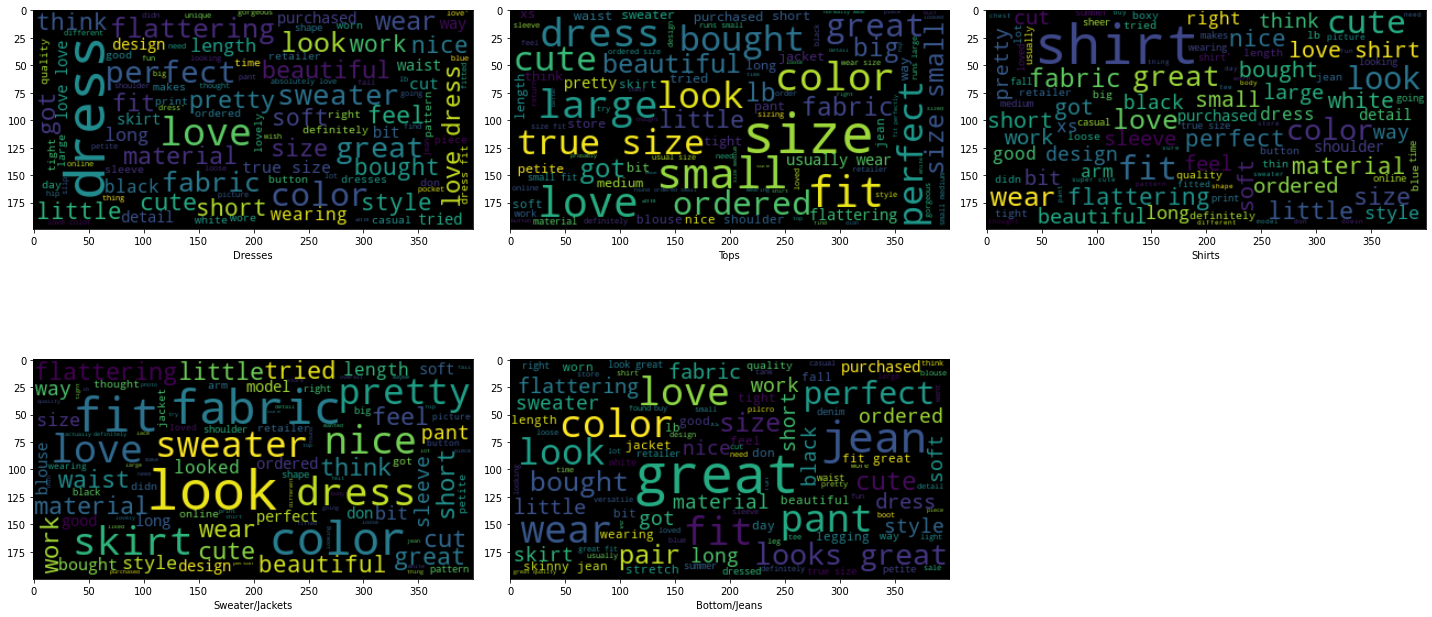

In [ ]:
fig = plt.figure(figsize=[20,10])
temp = pd.DataFrame()
for count,i in enumerate(data['NMF_TOPIC_NAME'].unique()):
  ax=fig.add_subplot(2,3,count+1)
  temp = data[data['NMF_TOPIC_NAME']==i]
  temp_text= str(["".join(i) for i in temp['clean_review']])
  wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(temp_text)
  ax.imshow(wordcloud, interpolation="bilinear")
  ax.set_xlabel(i)
  #ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
mapping ={'0':'Tops','1':'Dresses','2':'Dresses','3':'Sweater/Jackets','4':'Shirts','5':'Bottom/Jeans'}

In [ ]:
data['NMF_TOPIC_NAME'] = data['NMF_TOPIC'].astype(str).map(mapping)

In [ ]:
data.head(50)

,Review Text,clean_review,LDA_TOPIC,NMF_TOPIC,NMF_TOPIC_NAME
0,Absolutely wonderful - silky and sexy and comfortable,absolutely wonderful silky sexy,5,2,Dresses
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",love dress sooo pretty happened find store glad bc ordered online bc petite bought petite love length hits little knee definitely true midi truly petite,1,2,Dresses
2,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",high hopes dress wanted work initially ordered petite small usual size found outrageously small small fact zip reordered petite medium ok overall half fit nicely half tight layer somewhat cheap net layers imo major design flaw net layer sewn directly zipper,4,0,Tops
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",love love love jumpsuit fun flirty fabulous time wear,3,2,Dresses
4,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,this shirt flattering adjustable tie perfect length wear leggings sleeveless pairs cardigan love shirt,3,4,Shirts
5,"I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.",love tracy reese dresses petite feet tall usually wear p brand dress pretty package lot dress skirt long overwhelmed small frame stranger alterations shortening narrowing skirt away embellishment garment love color idea style work returned dress,4,1,Dresses
6,"I aded this in my basket at hte last mintue to see what it would look like in person. (store pick up). i went with teh darkler color only because i am so pale :-) hte color is really gorgeous, and turns out it mathced everythiing i was trying on with it prefectly. it is a little baggy on me and hte xs is hte msallet size (bummer, no petite). i decided to jkeep it though, because as i said, it matvehd everything. my ejans, pants, and the 3 skirts i waas trying on (of which i ]kept all ) oops.",aded basket hte mintue look like person store pick went teh darkler color pale hte color gorgeous turns mathced everythiing trying prefectly little baggy hte xs hte msallet size bummer petite decided jkeep said matvehd ejans pants skirts waas trying kept oops,1,3,Sweater/Jackets
7,"I ordered this in carbon for store pick up, and had a ton of stuff (as always) to try on and used this top to pair (skirts and pants). everything went with it. the color is really nice charcoal with shimmer, and went well with pencil skirts, flare pants, etc. my only compaint is it is a bit big, sleeves are long and it doesn't go in petite. also a bit loose for me, but no xxs... so i kept it and wil ldecide later since the light color is already sold out in hte smallest size...",ordered carbon store pick ton stuff try pair skirts pants went color nice c